# **Jupyter Notebook for GCR**
</br>

## **Table of Content**

>### 0. Introduction
>### 1. 환경 구성
>### 2. Train Workflow
>### 3. Inference Workflow
>### 4. Batch Running
>### 5. 문의 및 기능 개발 요청
>### 6. References   

<br>

## **0. Introduction**

#### 본 sample notebook은 GCR의 구조와 각 asset의 역할과 산출물, 그 사용법을 처음 접하는 분들이 알기 쉽게 이해할 수 있도록 제작되었습니다.   

[ **1. 환경 구성** ]에서는 ALO 등 환경 설치 방법을 설명하고,   
[ **2. Train workflow** ]와 [ **3. Inference workflow** ]는 각각 train workflow와 inference workflow의 사용 방법과 산출물을 설명하며,   
[ **4. Batch running** ]에서는 sample notebook이 아닌 실제 과제 운용 시에 GCR contents를 수행하는 방법을 설명하고   
[ **5. 문의 및 기능 개발 요청** ]에서는 사용 중 문의 사항이나 기능에 대한 수정/개발 요청 방법을,   
[ **6. References** ]에서는 추가로 참고하실 collab 문서 등에 대한 links를 제공합니다.

***NOTE!!!***   
<br />
본 sample notebook의 제작 시점 (2024년 2월) 현재, ALO version이 기존 2.1에서 2.2로 변경되었으나 ALO 2.2의 jupyter notebook 지원은 완료되지 않은 상황입니다.   
이에 따라, 본 sample notebook은 [ **2. Train workflow** ]와 [ **3. Inference workflow** ]는 ALO 2.1에 맞춰 제작되었고, [ **4. Batch running** ]은 ALO 2.2에 맞춰 제작된 점 양해 부탁 드립니다.   
<br />

#### Notebook의 Workflow는 다음과 같이 구성됩니다.
> Workflow NAME (ex. Train Workflow)

>> Workflow 구성 설명
>>> **A** asset : A asset 설명   
>>> **B** asset : B asset 설명   
>>> ...

>> Workflow Setup 
>>> Workflow Setup 코드

>> [0] **A** asset
>>> parameter 설명 및 실행 코드 

>> [1] **B** asset
>>> parameter 설명 및 실행 코드

>> ..

</br>

#### 각 Asset은 동작확인을 위해 다음과 같이 구성됩니다.
> ASSET NAME

>> 주요 Parameter 설명
>>> param1: param1 설명   
>>> ***param2***: param2 설명 [*option1 / option2 / option3*]   
>>> param3: param3 설명 [*option1 / option2*]   
>>> ..

>> Parameter 설정부
>>> #################   
>>> parameter 설정 코드   
>>> #################   

>> Asset 실행부
>>> #################   
>>> Asset 실행 코드   
>>> #################   

Asset 별로 experimental_plan.yaml에 주어진 parameter에 대한 설명이 주어집니다.   
설명에 따라 parameter 변경 시 experimental_plan.yaml을 직접 수정하거나, Parameter 설정부에서 코드 실행을 통해 바꿀 수 있습니다.   
위에서 param2와 같이 ***Bold Italic***으로 표기된 변수는 필수 설정 변수로, 최초 실행 또는 데이터가 바뀔 시 꼭 다시 설정해주어야 하는 변수를 의미합니다.   
설정된 parameter로 asset을 실행할 수 있습니다. 또한 Parameter를 변경해가며 Asset 실행 결과 변화를 관찰할 수 있습니다.

</br>

## **1. 환경 구성**

#### GCR을 사용하기 위해서는 아래와 같은 방법으로 데이터를 준비해야 합니다.
> 1. Train, Inference 두 개의 데이터셋을 준비합니다. 본 notebook에서는 GCR 설치 시 함께 제공되는 default sample data를 이용합니다.  
> 2. GCR은 supervised learning을 제공하는 AI content이므로 train set에는 label에 해당하는 column이 존재해야 합니다. 또한, label에 해당하는 column은 결측치가 있어서는 안됩니다.
> 3. Train set과 inference set은 label column을 제외하면 column명 list가 일치해야 합니다.
> 4. Graph 구성을 위해 사용자가 지정해줘야 할 center node column ('center_node_column')도 결측치가 있어서는 안됩니다.   

***GCR은 Graph-powered ML을 제공하므로, label 및 center node columns 외의 column들에 대해서는 결측치에 대한 전처리가 불필요하며, 모든 columns에 대해 범주형 데이터에 대한 전처리도 필요하지 않습니다***   
<br />

#### ALO 설치 및 configuration 설정 방법은 다음과 같습니다.
<br />

***NOTE!!!***   
<br />
여기에 설명하는 ALO 설치 방법은 sample notebook을 수행하기 위한 ALO 2.1 설치 방법입니다.   
만일 console에서 GCR 기반의 AI solution을 개발하시는 경우라면, [ **4. Batch running** ]에 설명된 ALO 2.2 설치를 진행해야 합니다.   
향후 ALO 2.2의 jupyter notebook 지원 기능 개발이 완료되면, sample notebook 수행 시에도 ALO 2.2 설치로 통일될 예정입니다.      
<br />

1. 최상위 디렉토리에서 install.sh를 실행합니다
> source install.sh
2. install.sh를 실행하면 alo 디렉토리가 설치됩니다.
3. 가상환경을 설치 및 실행합니다.
> conda create -n gcr python=3.10   
> conda init bash   
> source ~/.bashrc   
> conda activate gcr    
3. alo/config 디렉토리로 이동하여 experimental_plan.yaml 파일을 오픈합니다.
4. external_path의 load_train_data_path에 아래와 같이 사용할 데이터의 경로(디렉토리)를 입력합니다.

>```
>external_path:
>    - load_train_data_path: /nas001/gcr_test_data/sample/
>    - load_inference_data_path:
>    - save_train_artifacts_path:
>    - save_inference_artifacts_path:
>```

***NOTE!!!***   
<br />
현재 sample notebook을 default sample data로 정상적으로 수행하기 위해서는, 아래와 같이 external_path를 설정해줘야 합니다.   
이는, GCR 2.0.0은 ALO 2.2에 맞추어 개발되었으나, sample notebook을 수행하기 위한 ALO 2.2 지원이 개발 중인 관계로 본 sample notebook은 ALO 2.1을 사용하고 있는데, ALO 2.2와 ALO 2.1은 요구하는 sample data 위치가 상이하기 때문입니다.   
<br />

>```
>external_path:
>    - load_train_data_path: ../../sample_data/train
>    - load_inference_data_path: ../../sample_data/test
>```

5. 필수 변경 parameter를 변경합니다. 나머지 parameter는 컨텐츠 yaml에 제공된 default 값을 사용해도 괜찮습니다.
6. 아래 **ALO Setup**을 실행합니다.

### ALO Setup
라이브러리 설치 및 컨텐츠 다운로드를 위해 아래 코드를 실행 해주세요

In [9]:
## 이하 cell들을 수행하다가 error가 발생하여 이곳부터 재 수행해야 할 경우, 아래 code를 열어 초기 위치로 돌아가 주세요.
#os.chdir(os.path.abspath(os.path.join('/home/jovyan/240216_aicontents_gcr_2.0.0/gcr')))

In [10]:
import argparse
import time
import os
import copy
os.chdir(os.path.abspath(os.path.join('./alo')))

from src.alo import ALO
from src.alo import AssetStructure
alo = ALO(); alo.set_proc_logger(); alo.preset()
pipelines = list(alo.asset_source.keys())

from src.external import external_load_data, external_save_artifacts
def run(step, pipeline, asset_structure):
    # 반복되는 작업을 함수로 변환
    asset_config = alo.asset_source[pipeline]
    return alo.process_asset_step(asset_config[step], step, pipeline, asset_structure)

# pipeline list 를 가지고 옴
pipelines = list(alo.asset_source.keys())
pipelines

[2024-02-16 05:26:46,144][PROCESS][INFO]: Successfully loaded << experimental_plan.yaml >> from: 
 /home/jovyan/240216_aicontents_gcr_2.0.0/gcr/alo/config/experimental_plan.yaml
[2024-02-16 05:26:46,178][PROCESS][INFO]: None of << compare yaml >> version is matched. 
 However, The version of << experimental_plan.yaml >> is recognized as same as compare yaml version << 2.0 >> 
[2024-02-16 05:26:46,181][PROCESS][INFO]: Success versioning up experimental_plan.yaml : 2.0 --> 2.1 (version ref. : compare yaml version)


['train_pipeline', 'inference_pipeline']

## **2. Train Workflow**

#### GCR의 Train Workflow 구성은 다음과 같습니다.
> **[0]** Input asset : *사용자가 지정한 경로로부터 데이터를 Import*   
> **[1]** Readiness asset : *Train 실시 전 입력 데이터의 오류를 검사하여 다음 step을 진행할 지 결정*   
> **[2]** Train1 asset : *Train set 데이터를 토대로 그래프를 구성하고 필요한 임베딩 추출*   
> **[3]** Preprocess asset : *(필요시) 결측치 처리 및 라벨 인코딩*   
> **[4]** Train2 asset : *ML 모델 학습*   
> **[5]** Output asset : *모델 학습과정에서 생성된 산출물을 올바른 경로에 저장*   

#### Train Workflow Setup
아래 코드를 실행하여 Train Workflow에 필요한 라이브러리를 먼저 설치 해주세요.

In [11]:
alo.external_load_data(pipelines[0]) # external load data for train_pipeline
# 사용하는 pipeline의 package를 설치
# train = 0, infernence = 1을 선택해야 하고 둘다 설치 해야함
pipeline = pipelines[0]
alo.install_steps(pipeline, alo.control["get_asset_source"])
 # 초기 data structure 구성
alo.set_asset_structure()
init_asset_structure = copy.deepcopy(alo.asset_structure)

[2024-02-16 05:26:50,789][PROCESS][WARNING]: You did not write any << s3_private_key_file >> in the config yaml file. When you wanna get data from s3 storage, 
                                 you have to write the s3_private_key_file path or set << AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY >> in your os environment. 

[2024-02-16 05:26:50,794][PROCESS][INFO]: Successfuly removed << /home/jovyan/240216_aicontents_gcr_2.0.0/gcr/alo/input/train/ >> before loading external data.
[2024-02-16 05:26:50,797][PROCESS][INFO]: << ../../sample_data/train >> may be relative path. The reference folder of relative path is << config/ >>. 
 If this is not appropriate relative path, Loading external data process would raise error.
[2024-02-16 05:26:50,838][PROCESS][INFO]: ==================== Successfully done loading external data: 
 ../../sample_data/train --> /home/jovyan/240216_aicontents_gcr_2.0.0/gcr/alo/input/train/
[2024-02-16 05:26:50,841][PROCESS][INFO]: Successfuly finish loading << ../../sam

  Using cached cmake-3.28.3-py2.py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (6.3 kB)
  Using cached lit-17.0.6-py3-none-any.whl
  Using cached MarkupSafe-2.1.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.0 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
Using cached filelock-3.13.1-py3-none-any.whl (11 kB)
Using cached Jinja2-3.1.3-py3-none-any.whl (133 kB)
Using cached networkx-3.2.1-py3-none-any.whl (1.6 MB)
Using cached sympy-1.12-py3-none-any.whl (5.7 MB)
Using cached typing_extensions-4.9.0-py3-none-any.whl (32 kB)
Using cached MarkupSafe-2.1.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (25 kB)
Using cached cmake-3.28.3-py2.py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (26.3 MB)
[2024-02-16 05:29:41,309][PROCESS][INFO]: Start checking existence & installing package - torchbiggraph@git+https://github.com/seongwooxp/PyTorch-BigGraph | Progress: ( 3 / 15 total packages ) 
[2024-02-16 05:29:41,351][PRO

  Running command git clone --filter=blob:none --quiet https://github.com/seongwooxp/PyTorch-BigGraph /tmp/pip-install-wfsjmuqj/torchbiggraph_cd2464b475644c7b9d7f75edbb19fa34


  Resolved https://github.com/seongwooxp/PyTorch-BigGraph to commit 24c9aa0c6725c08e1c526fd9395cd7dfb4777e26
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached attrs-23.2.0-py3-none-any.whl.metadata (9.5 kB)
  Using cached h5py-3.10.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.5 kB)
  Using cached tqdm-4.66.2-py3-none-any.whl.metadata (57 kB)
Using cached attrs-23.2.0-py3-none-any.whl (60 kB)
Using cached h5py-3.10.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.8 MB)
Using cached tqdm-4.66.2-py3-none-any.whl (78 kB)
  Created wheel for torchbiggraph: filename=torchbiggraph-1.0.1.dev0-cp310-cp310-linux_x86_64.whl size=214198 sha256=d9155efffb23743bff50d0c61cd98b0b6a926d9d9d8e968515ae2741d0cebef0
  Stored in directory: /tmp/pip-ephem-wheel-cache-pa9vm0p6/wheels/41/24/81/08e4b6d696226324131f45e3f4b489ec0c554156a623c3eaf0
Successfully built torchbiggraph
[2024-02-16 05:30:27,807][

  Using cached joblib-1.3.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.3.0-py3-none-any.whl.metadata (13 kB)
Using cached category_encoders-2.6.3-py2.py3-none-any.whl (81 kB)
Using cached patsy-0.5.6-py2.py3-none-any.whl (233 kB)
Using cached scikit_learn-1.4.0-1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)
Using cached scipy-1.12.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.4 MB)
Using cached statsmodels-0.14.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.8 MB)
Using cached joblib-1.3.2-py3-none-any.whl (302 kB)
Using cached threadpoolctl-3.3.0-py3-none-any.whl (17 kB)
[2024-02-16 05:31:03,939][PROCESS][INFO]: ======================================== Start dependency installation : << train2 >> 
[2024-02-16 05:31:03,944][PROCESS][INFO]: Start checking existence & installing package - numpy==1.25.2 | Progress: ( 5 / 15 total packages ) 
[2024-02-16 05:31:03,997][PROCESS][INFO]: >>> Start installing pac

  Using cached numba-0.59.0-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (2.7 kB)
  Using cached cloudpickle-3.0.0-py3-none-any.whl.metadata (7.0 kB)
  Using cached llvmlite-0.42.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.8 kB)
Using cached shap-0.44.1-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (535 kB)
Using cached cloudpickle-3.0.0-py3-none-any.whl (20 kB)
Using cached numba-0.59.0-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (3.7 MB)
Using cached llvmlite-0.42.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (43.8 MB)
[2024-02-16 05:31:47,111][PROCESS][INFO]: Start checking existence & installing package - lightgbm | Progress: ( 10 / 15 total packages ) 
[2024-02-16 05:31:47,168][PROCESS][INFO]: >>> Start installing package - lightgbm
  Using cached lightgbm-4.3.0-py3-none-manylinux_2_27_x86_64.whl
[2024-02-16 05:31:49,570][PROCESS][INFO]: Start c

Using cached lifelines-0.28.0-py3-none-any.whl (349 kB)
Using cached autograd-1.6.2-py3-none-any.whl (49 kB)
Using cached formulaic-1.0.1-py3-none-any.whl (94 kB)
Using cached wrapt-1.16.0-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (80 kB)
[2024-02-16 05:33:36,700][PROCESS][INFO]: Start checking existence & installing package - numba==0.58.0 | Progress: ( 13 / 15 total packages ) 
[2024-02-16 05:33:36,760][PROCESS][INFO]: >>> Start installing package - numba==0.58.0
  Using cached numba-0.58.0-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (2.7 kB)
  Using cached llvmlite-0.41.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.8 kB)
Using cached numba-0.58.0-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (3.6 MB)
Using cached llvmlite-0.41.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (43.6 MB)
  Attempting uninstall: llvmlite
    Found existing installation: llv

### [0] Input asset

#### 주요 Parameter
- ***input_path*** : Extenal Path에서 받은 데이터는 *alo/input/train*에 저장됩니다. 이 중에서 사용할 데이터가 저장된 디렉터리 명을 작성해주시면 됩니다.
- x_columns : 데이터의 모든 컬럼을 활용하지 않는 경우엔 직접 선택해서 사용할 수 있습니다.
- use_all_x : 데이터의 모든 컬럼을 사용하는 경우 True로 설정하고 사용합니다. 이 경우 x_columns는 빈칸이어야 합니다. [*True / False*]
- ***y_column*** : Classification, Regression을 위해서는 Label이 있어야 합니다. Label에 해당하는 컬럼을 작성합니다.
- groupkey_columns : 특정 컬럼 명을 기준으로 데이터를 그룹으로 나누어 모델링을 하고 싶을 경우에 사용합니다.
- drop_columns : use_all_x가 True일 때 삭제하고 싶은 컬럼을 입력합니다.
- time_column : 데이터에 시간 컬럼이 있을 경우 입력합니다.
- concat_dataframes : 같은 형태 csv 파일 여러 개를 input data로 불러올 시, concat 여부를 선택합니다. [*True / False*]
- encoding : pd.read_csv() 시에 사용할 encoding 방법을 설정합니다.

#### Parameter 설정

In [12]:
# GCR asset 순서에 따라 step 순서를 입력합니다. (input(0) - readiness(1) - train1(2) - preprocess(3) - train2(4) - output(5))
step = 0
alo.asset_structure= copy.deepcopy(init_asset_structure)
alo.asset_structure.args = alo.get_args(pipeline, step)

# 아래 주석을 풀어 input asset argument를 원하는 값으로 수정합니다. 
#asset_structure.args['x_columns'] = ['']
alo.asset_structure.args

{'input_path': 'train',
 'x_columns': None,
 'use_all_x': True,
 'y_column': 'target',
 'groupkey_columns': None,
 'drop_columns': None,
 'time_column': None,
 'concat_dataframes': None,
 'encoding': None}

#### Input asset 실행 

In [13]:
input_asset_structure = run(step, pipeline, alo.asset_structure)

# input asset의 결과 dataframe은 input_asset_structure.data['dataframe']으로 확인할 수 있습니다.
input_asset_structure.data['dataframe'].head(10)

[2024-02-16 05:35:10,075][USER][INFO][train_pipeline][input]: >> Load path : ['/home/jovyan/240216_aicontents_gcr_2.0.0/gcr/alo/input/train/train/']
[2024-02-16 05:35:10,196][USER][INFO][train_pipeline][input]: >> The file for batch data has been loaded. (File name: /home/jovyan/240216_aicontents_gcr_2.0.0/gcr/alo/input/train/train/samples.csv)
[2024-02-16 05:35:10,200][USER][INFO][train_pipeline][input]: You set the << use_all_x >> as << True >> in the yaml file. So skip checking dataframe columns existence.
[2024-02-16 05:35:10,216][USER][INFO][train_pipeline][input]: ==================== Success loading dataframe ====================
[2024-02-16 05:35:10,219][USER][INFO][train_pipeline][input]: >> Start processing ignore columns & drop columns: ['/home/jovyan/240216_aicontents_gcr_2.0.0/gcr/alo/input/train/train/samples.csv']
[2024-02-16 05:35:10,232][USER][INFO][train_pipeline][input]: >> You set the << use_all_x >> parameter as << True >> in your config yaml. (So, these x_columns 

[2024-02-16 05:35:10,069][ASSET][INFO][train_pipeline][input]: 

============================= ASSET START =============================
- time (UTC)        : 2024-02-16 05:35:10
- current step      : input
- asset branch.     : tabular_2.0
- alolib ver.       : 2.1
- alo ver.          : 2.1
- load envs. keys   : dict_keys(['project_home', 'solution_metadata_version', 'artifacts', 'alo_version', 'interface_mode', 'proc_start_time', 'save_train_artifacts_path', 'save_inference_artifacts_path', 'pipeline', 'step', 'num_step', 'asset_branch', 'load_data', 'load_config', 'save_data', 'save_config', 'log_file_path'])
- load args. keys   : dict_keys(['input_path', 'x_columns', 'use_all_x', 'y_column', 'groupkey_columns', 'drop_columns', 'time_column', 'concat_dataframes', 'encoding'])
- load config. keys : dict_keys(['meta'])
- load data keys    : dict_keys([])


[2024-02-16 05:35:10,233][ASSET][INFO][train_pipeline][input]: 

============================= ASSET FINISH ======================

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target,ID
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,1,CX0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,1,CX1
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,1,CX2
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,1,CX3
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,1,CX4
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,1,CX5
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,1,CX6
7,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,0,CX9
8,37,Private,280464,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0,0,80,United-States,0,CX10
9,30,State-gov,141297,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,India,0,CX11


### [1] Readiness asset

#### 주요 Parameter   
<br />
GCR 2.0.0부터는 data readiness check을 수행하기 위한 readiness asset이 추가되었습니다.   
<br />
Readiness asset은 AI content 마다 수행하는 기능과 parameter들이 상이한데, 이는 각 AI content의 동작에 맞도록 input data의 오류를 검사하기 때문입니다.   
Input data에서 오류가 발견된 경우, readiness asset은 error를 발생시켜 전체 pipeline을 멈추게 됩니다. 이 때, 발생된 error는 log file에서 확인하실 수 있습니다.   
<br />
GCR의 readiness asset은 label에 해당하는 column에 결측치가 있는지, graph의 center node에 해당하는 column에 결측치가 있는지를 확인합니다. 
<br />  
이를 위해 필요한 parameter들이 아래와 같습니다.   
<br />
현재 readiness asset이 alpha version인 관계로, 다른 asset과 parameter 중복이 존재하는데, 이 문제는 readiness asset 정식 version이 release되는 시점 (24년 3월)에 정리될 예정이오니 양해 부탁 드립니다.   
<br />

- ***x_columns*** : 데이터의 모든 컬럼을 활용하지 않는 경우엔 직접 선택해서 사용할 수 있습니다.
- ***y_column*** : Classification, Regression을 위해서는 Label이 있어야 합니다. Label에 해당하는 컬럼을 작성합니다.
- ***groupkey_columns*** : 특정 컬럼 명을 기준으로 데이터를 그룹으로 나누어 모델링을 하고 싶을 경우에 사용합니다.
- ***center_node_column*** : 특정 컬럼 명을 기준으로 데이터를 그룹으로 나누어 모델링을 하고 싶을 경우에 사용합니다.


#### Parameter 설정

In [16]:
# GCR asset 순서에 따라 step 순서를 입력합니다. (input(0) - readiness(1) - train1(2) - preprocess(3) - train2(4) - output(5))
step = 1
alo.asset_structure= copy.deepcopy(input_asset_structure)
alo.asset_structure.args = alo.get_args(pipeline, step)

# 아래 주석을 풀어 input asset argument를 원하는 값으로 수정합니다. 
#asset_structure.args['x_columns'] = ['']
alo.asset_structure.args

{'x_columns': None,
 'y_column': 'target',
 'groupkey_columns': None,
 'center_node_column': 'ID'}

#### Readiness asset 실행 

In [17]:
readiness_asset_structure = run(step, pipeline, alo.asset_structure)

# Readiness asset의 결과 dataframe은 readiness_asset_structure.data['dataframe']으로 확인할 수 있습니다.
readiness_asset_structure.data['dataframe'].head(10)

[2024-02-16 05:59:41,411][ASSET][INFO][train_pipeline][readiness]: 

============================= ASSET START =============================
- time (UTC)        : 2024-02-16 05:59:41
- current step      : readiness
- asset branch.     : gcr-0.9.0
- alolib ver.       : 2.1
- alo ver.          : 2.1
- load envs. keys   : dict_keys(['project_home', 'solution_metadata_version', 'artifacts', 'alo_version', 'interface_mode', 'proc_start_time', 'save_train_artifacts_path', 'save_inference_artifacts_path', 'pipeline', 'step', 'num_step', 'asset_branch', 'load_data', 'load_config', 'save_data', 'save_config', 'log_file_path', 'prev_step'])
- load args. keys   : dict_keys(['x_columns', 'y_column', 'groupkey_columns', 'center_node_column'])
- load config. keys : dict_keys(['meta', 'data_source_type', 'time_format', 'time_column', 'x_columns', 'input_path', 'group_cnt', 'group_keys', 'y_column', 'input_asset_df_path', 'ignore_columns'])
- load data keys    : dict_keys(['dataframe'])


In __init__:

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target,ID
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,1,CX0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,1,CX1
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,1,CX2
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,1,CX3
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,1,CX4
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,1,CX5
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,1,CX6
7,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,0,CX9
8,37,Private,280464,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0,0,80,United-States,0,CX10
9,30,State-gov,141297,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,India,0,CX11


### [2] Train1 asset (기존 graph asset)

GCR의 가장 핵심이 되는 asset입니다. Raw Data를 임베딩으로 모두 변환하여 별도의 전처리 없이 더 높은 성능의 ML모델을 획득하기 위한 Tool이 됩니다.
#### 주요 Parameter
- center_node_column : 방사형 그래프는 중심 컬럼을 기준으로 그래프를 구성합니다. 데이터의 대표가 되는 컬럼을 선택하면 됩니다.(ex. ID, Name 등)
- embedding_column : 임베딩의 대상이 되는 컬럼을 선택합니다. 라벨이 center_node_column과 대응하지 않는 경우가 있을 수 있습니다. 이때는 label이 대응하는 컬럼을 embedding column으로 설정합니다.
- dimension : 임베딩 출력 벡터의 차원수를 설정합니다.
- num_epochs: Embedding 학습을 위한 epoch을 설정합니다.
- num_partitions : partition 수를 설정합니다. 증가시켜 메모리 사용량을 줄일 수 있습니다.
- use_gpu : 운영 시스템이 GPU를 지원할 경우, true로 설정하여 GPU를 사용할 수 있습니다.

#### Parameter 설정

In [18]:
# GCR asset 순서에 따라 step 순서를 입력합니다. (input(0) - readiness(1) - train1(2) - preprocess(3) - train2(4) - output(5))
step = 2 
alo.asset_structure= copy.deepcopy(readiness_asset_structure)
alo.asset_structure.args = alo.get_args(pipeline, step)

# 아래 주석을 풀어 graph asset argument를 원하는 값으로 수정합니다. 
#asset_structure.args['dimension'] = 128
alo.asset_structure.args

{'center_node_column': 'ID',
 'embedding_column': 'ID',
 'dimension': 128,
 'num_epochs': 1,
 'num_partitions': None,
 'use_gpu': None}

#### Train1 asset 실행 

In [19]:
# asset 실행
train1_asset_structure=run(step, pipeline, alo.asset_structure)

# graph asset의 결과 dataframe은 train1_asset_structure.data['dataframe']으로 확인할 수 있습니다. 
train1_asset_structure.data['dataframe'].head(10)

[2024-02-16 06:06:35,857][ASSET][INFO][train_pipeline][train1]: Successfully got model path for saving or loading your AI model: 
 /home/jovyan/240216_aicontents_gcr_2.0.0/gcr/alo/.train_artifacts/models/train/
[2024-02-16 06:06:35,860][ASSET][INFO][train_pipeline][train1]: 

============================= ASSET START =============================
- time (UTC)        : 2024-02-16 06:06:35
- current step      : train1
- asset branch.     : develop
- alolib ver.       : 2.1
- alo ver.          : 2.1
- load envs. keys   : dict_keys(['project_home', 'solution_metadata_version', 'artifacts', 'alo_version', 'interface_mode', 'proc_start_time', 'save_train_artifacts_path', 'save_inference_artifacts_path', 'pipeline', 'step', 'num_step', 'asset_branch', 'load_data', 'load_config', 'save_data', 'save_config', 'log_file_path', 'prev_step'])
- load args. keys   : dict_keys(['center_node_column', 'embedding_column', 'dimension', 'num_epochs', 'num_partitions', 'use_gpu'])
- load config. keys : dict

[2024-02-16 06:06:38.460650] - Edges will be partitioned in 1 x 1 buckets.
[2024-02-16 06:06:38.698898] - Processed 26072 edges in total
[2024-02-16 06:06:38.700022] Preparing edge path /home/jovyan/240216_aicontents_gcr_2.0.0/gcr/alo/.train_artifacts/models/train/partitions/edges_partitioned_rel_14, out of the edges found in /home/jovyan/240216_aicontents_gcr_2.0.0/gcr/alo/.train_artifacts/models/train/tsvs/rel_14.tsv
[2024-02-16 06:06:38.701246] - Edges will be partitioned in 1 x 1 buckets.
[2024-02-16 06:06:38.833017] - Processed 26072 edges in total
[2024-02-16 06:06:38.834403] Preparing edge path /home/jovyan/240216_aicontents_gcr_2.0.0/gcr/alo/.train_artifacts/models/train/partitions/edges_partitioned_rel_12, out of the edges found in /home/jovyan/240216_aicontents_gcr_2.0.0/gcr/alo/.train_artifacts/models/train/tsvs/rel_12.tsv
[2024-02-16 06:06:38.835569] - Edges will be partitioned in 1 x 1 buckets.
[2024-02-16 06:06:38.968935] - Processed 26072 edges in total
[2024-02-16 06:06

/home/jovyan/conda/envs/gcr/lib/python3.10/site-packages/torchbiggraph/util.py:222: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = tensor.storage_type()._new_shared(size.numel())
/home/jovyan/conda/envs/gcr/lib/python3.10/site-packages/torch/storage.py:959: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if self.device.type not in ['cpu', 'cuda']:
/home/jovyan/conda/envs/gcr/lib/python3.10/site-packages/torch/storage.py:962: UserWarning: TypedStorage is deprecated. It will be removed in the future and Unty

[Embedding Complete]
In __del__: pbg deleted
[2024-02-16 06:07:01,537][ASSET][INFO][train_pipeline][train1]: 

============================= ASSET FINISH ===========================
- time (UTC)        : 2024-02-16 06:07:01
- current step      : train1
- save config. keys : dict_keys(['meta', 'data_source_type', 'time_format', 'time_column', 'x_columns', 'input_path', 'group_cnt', 'group_keys', 'y_column', 'input_asset_df_path', 'ignore_columns', 'center_node_column'])
- save data keys    : dict_keys(['dataframe'])


[2024-02-16 06:07:01,540][PROCESS][INFO]: ==================== Finish pipeline: train_pipeline / step: train1


,EMB_000,EMB_001,EMB_002,EMB_003,EMB_004,EMB_005,EMB_006,EMB_007,EMB_008,EMB_009,...,EMB_119,EMB_120,EMB_121,EMB_122,EMB_123,EMB_124,EMB_125,EMB_126,EMB_127,target
0,-0.031787,0.005793,-0.017358,0.001166,-0.011912,-0.014894,0.023695,-0.019463,-0.009830,0.007817,...,-0.014636,0.005233,-0.001315,-0.011508,0.020522,0.006062,-0.023483,-0.003045,0.002571,1
1,0.012843,-0.003486,-0.014708,0.018442,-0.051791,-0.005231,-0.015779,-0.124171,0.021208,0.050181,...,-0.029428,0.029274,0.008022,-0.004988,-0.028250,0.003807,-0.072039,0.013300,0.001254,1
2,-0.063415,-0.041987,-0.051871,-0.003035,0.003508,-0.021524,0.021369,-0.010615,0.013744,0.018987,...,-0.021161,-0.001802,0.019800,-0.032344,0.031109,0.008710,-0.012333,0.041268,-0.001675,1
3,-0.008741,-0.024126,-0.016491,0.003069,-0.003847,-0.000397,-0.012842,-0.018499,0.019406,0.015205,...,-0.008201,0.003023,0.011535,-0.008696,-0.006763,-0.002119,0.002639,0.016253,-0.003845,1
4,-0.045790,-0.004882,-0.029868,-0.000906,0.000048,-0.019189,0.034408,0.003233,-0.013011,0.001010,...,-0.011713,-0.005105,-0.003003,-0.018553,0.033998,0.011407,-0.012937,0.004715,0.006163,1
5,-0.030210,-0.003547,-0.029647,0.004381,-0.015021,-0.017025,0.026504,-0.033041,-0.000372,0.016892,...,-0.020287,0.005612,-0.001324,-0.017195,0.018050,0.009064,-0.033053,0.008564,0.007816,1
6,-0.017661,0.003340,-0.005678,-0.011856,0.034336,-0.003125,0.019840,0.077678,-0.011791,-0.027356,...,0.014332,-0.015012,-0.008219,-0.002600,0.023903,-0.003288,0.046034,-0.011117,0.010053,1
7,-0.006494,-0.011239,-0.027089,0.014070,-0.046269,-0.009452,-0.010248,-0.117692,0.021509,0.051211,...,-0.032783,0.025134,0.010483,-0.009364,-0.013481,0.008869,-0.068844,0.020472,0.000189,0
8,-0.027000,-0.026708,-0.030103,0.005016,-0.009542,-0.012196,0.007530,-0.033858,0.006622,0.019057,...,-0.016460,0.002959,0.011368,-0.021313,0.002418,0.004780,-0.021526,0.025197,0.001196,0
9,-0.006076,0.002377,-0.016305,0.013066,-0.035905,-0.005674,-0.004641,-0.082531,0.003839,0.027448,...,-0.024313,0.012237,0.000493,-0.001625,-0.003968,0.010324,-0.048183,-0.002195,0.003067,0


### [3] Preprocess asset 

GCR은 데이터 전처리가 불필요하기 때문에 Preprocess asset의 역할은 크지 않습니다. 다만 사용자가 임베딩 외에 raw data를 학습에 사용하는 경우 (즉, extra_columns_for_ml 설정시) 결측치를 처리하기 위한 용도입니다.
#### 주요 Parameter
- handling_missing : 결측치 처리 방식을 지정합니다. 'interpolation' 또는 'fill_number' 중에 선택할 수 있으며 GCR에서는 'interpolation'을 권장합니다.
- ***handling_encoding_y_column*** : input asset의 y_column과 동일하게 설정합니다. (필수)
- ***handling_encoding_y*** : y_column의 인코딩 방식을 설정합니다. GCR에서는 'label'로 설정합니다.
- handling_scaling_x : X 컬럼의 scaling 방식을 선택합니다.
- load_train_preprocess : False로 설정합니다. (inference workflow 전용)

#### Parameter 설정

In [20]:
# GCR asset 순서에 따라 step 순서를 입력합니다. (input(0) - readiness(1) - train1(2) - preprocess(3) - train2(4) - output(5))
step = 3 
alo.asset_structure = copy.deepcopy(train1_asset_structure)
alo.asset_structure.args = alo.get_args(pipeline, step)

# 아래 주석을 풀어 preprocess asset argument를 원하는 값으로 수정합니다. 
# asset_structure.args['handling_missing'] = dropna
alo.asset_structure.args

{'handling_missing': 'interpolation',
 'handling_encoding_y_column': 'target',
 'handling_encoding_y': 'label',
 'handling_scaling_x': 'none',
 'load_train_preprocess': False}

#### Preprocess asset 실행 

In [21]:
# asset 실행
preprocess_asset_structure=run(step, pipeline, alo.asset_structure)

# preprocess asset의 결과 dataframe은 preprocess_asset_structure.data['dataframe']으로 확인할 수 있습니다.  
preprocess_asset_structure.data['dataframe'].head(10)

[2024-02-16 06:15:15,129][ASSET][INFO][train_pipeline][preprocess]: Successfully got model path for saving or loading your AI model: 
 /home/jovyan/240216_aicontents_gcr_2.0.0/gcr/alo/.train_artifacts/models/preprocess/
[2024-02-16 06:15:15,132][ASSET][INFO][train_pipeline][preprocess]: 

============================= ASSET START =============================
- time (UTC)        : 2024-02-16 06:15:15
- current step      : preprocess
- asset branch.     : release-1.2
- alolib ver.       : 2.1
- alo ver.          : 2.1
- load envs. keys   : dict_keys(['project_home', 'solution_metadata_version', 'artifacts', 'alo_version', 'interface_mode', 'proc_start_time', 'save_train_artifacts_path', 'save_inference_artifacts_path', 'pipeline', 'step', 'num_step', 'asset_branch', 'load_data', 'load_config', 'save_data', 'save_config', 'log_file_path', 'prev_step'])
- load args. keys   : dict_keys(['handling_missing', 'handling_encoding_y_column', 'handling_encoding_y', 'handling_scaling_x', 'load_tra

,EMB_000,EMB_001,EMB_002,EMB_003,EMB_004,EMB_005,EMB_006,EMB_007,EMB_008,EMB_009,...,EMB_119_nan,EMB_120_nan,EMB_121_nan,EMB_122_nan,EMB_123_nan,EMB_124_nan,EMB_125_nan,EMB_126_nan,EMB_127_nan,target_encoded_nan
0,-0.031787,0.005793,-0.017358,0.001166,-0.011912,-0.014894,0.023695,-0.019463,-0.009830,0.007817,...,-0.014636,0.005233,-0.001315,-0.011508,0.020522,0.006062,-0.023483,-0.003045,0.002571,1
1,0.012843,-0.003486,-0.014708,0.018442,-0.051791,-0.005231,-0.015779,-0.124171,0.021208,0.050181,...,-0.029428,0.029274,0.008022,-0.004988,-0.028250,0.003807,-0.072039,0.013300,0.001254,1
2,-0.063415,-0.041987,-0.051871,-0.003035,0.003508,-0.021524,0.021369,-0.010615,0.013744,0.018987,...,-0.021161,-0.001802,0.019800,-0.032344,0.031109,0.008710,-0.012333,0.041268,-0.001675,1
3,-0.008741,-0.024126,-0.016491,0.003069,-0.003847,-0.000397,-0.012842,-0.018499,0.019406,0.015205,...,-0.008201,0.003023,0.011535,-0.008696,-0.006763,-0.002119,0.002639,0.016253,-0.003845,1
4,-0.045790,-0.004882,-0.029868,-0.000906,0.000048,-0.019189,0.034408,0.003233,-0.013011,0.001010,...,-0.011713,-0.005105,-0.003003,-0.018553,0.033998,0.011407,-0.012937,0.004715,0.006163,1
5,-0.030210,-0.003547,-0.029647,0.004381,-0.015021,-0.017025,0.026504,-0.033041,-0.000372,0.016892,...,-0.020287,0.005612,-0.001324,-0.017195,0.018050,0.009064,-0.033053,0.008564,0.007816,1
6,-0.017661,0.003340,-0.005678,-0.011856,0.034336,-0.003125,0.019840,0.077678,-0.011791,-0.027356,...,0.014332,-0.015012,-0.008219,-0.002600,0.023903,-0.003288,0.046034,-0.011117,0.010053,1
7,-0.006494,-0.011239,-0.027089,0.014070,-0.046269,-0.009452,-0.010248,-0.117692,0.021509,0.051211,...,-0.032783,0.025134,0.010483,-0.009364,-0.013481,0.008869,-0.068844,0.020472,0.000189,0
8,-0.027000,-0.026708,-0.030103,0.005016,-0.009542,-0.012196,0.007530,-0.033858,0.006622,0.019057,...,-0.016460,0.002959,0.011368,-0.021313,0.002418,0.004780,-0.021526,0.025197,0.001196,0
9,-0.006076,0.002377,-0.016305,0.013066,-0.035905,-0.005674,-0.004641,-0.082531,0.003839,0.027448,...,-0.024313,0.012237,0.000493,-0.001625,-0.003968,0.010324,-0.048183,-0.002195,0.003067,0


### [4] Train2 asset (과거 train asset)

추출된 임베딩을 활용하여 ML모델을 학습합니다.
#### 주요 Parameter
- model_type: 목적에 맞는 학습 방식을 선택합니다. (classification/regression)
- data_split_method: HPO를 위한 데이터 분할 방식을 선택합니다. (cross_validate/train_test_split)
- evaluation_metric: classification의 경우 accuracy, precision, recall, f1-score / regression의 경우 mse, r2, mae, rmse 중 선택합니다.
- model_list: lightgbm, random-forest, gbm, Catboost 중 복수 선택 가능합니다.
- num_hpo: 설정 범위 내 hpo 횟수를 결정합니다.
- param_range: Search 범위를 지정합니다.
- shap_ratio: shap value 뽑을 데이터를 sampling 하는 비율을 결정합니다.

#### Parameter 설정

In [22]:
# GCR asset 순서에 따라 step 순서를 입력합니다. (input(0) - readiness(1) - train1(2) - preprocess(3) - train2(4) - output(5))
step = 4 
alo.asset_structure = copy.deepcopy(preprocess_asset_structure)
alo.asset_structure.args = alo.get_args(pipeline, step)

# 아래 주석을 풀어 train2 asset argument를 원하는 값으로 수정합니다.
alo.asset_structure.args['model_list'] = ['lgb']
alo.asset_structure.args

{'model_type': 'classification',
 'data_split_method': 'cross_validate',
 'evaluation_metric': 'accuracy',
 'model_list': ['lgb'],
 'num_hpo': 3,
 'param_range': {'rf': {'max_depth': 6, 'n_estimators': [300, 500]},
  'gbm': {'max_depth': [5, 7], 'n_estimators': [300, 500]},
  'ngb': {'col_sample': [0.6, 0.8], 'n_estimators': [100, 300]},
  'lgb': {'max_depth': [5, 9], 'n_estimators': [300, 500]},
  'cb': {'max_depth': [5, 9], 'n_estimators': [100, 500]}},
 'shap_ratio': 0.001}

#### Train2 asset 실행 

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
[2024-02-16 06:19:26,207][USER][INFO][train_pipeline][train2]: yaml에 입력된 task가 실행됩니다: classification


font: ['NanumBarunGothic']
[2024-02-16 06:19:26,169][ASSET][INFO][train_pipeline][train2]: Successfully got model path for saving or loading your AI model: 
 /home/jovyan/240216_aicontents_gcr_2.0.0/gcr/alo/.train_artifacts/models/train/
[2024-02-16 06:19:26,192][ASSET][INFO][train_pipeline][train2]: Successfully got << output path >> for saving your data into csv or jpg file: 
 /home/jovyan/240216_aicontents_gcr_2.0.0/gcr/alo/.train_artifacts/output/train2/ 
 - [NOTE] The names of output file must be fixed as << output.csv, output.jpg >> 
[2024-02-16 06:19:26,195][ASSET][INFO][train_pipeline][train2]: 

============================= ASSET START =============================
- time (UTC)        : 2024-02-16 06:19:26
- current step      : train2
- asset branch.     : tcr_v1.1.4
- alolib ver.       : 2.1
- alo ver.          : 2.1
- load envs. keys   : dict_keys(['project_home', 'solution_metadata_version', 'artifacts', 'alo_version', 'interface_mode', 'proc_start_time', 'save_train_artif

100%|██████████| 12/12 [00:14<00:00,  1.21s/it]

학습이 완료되었습니다.



@scoring_classification func. - label list:  {0, 1}@scoring_classification func. - label list: @scoring_classification func. - label list: 
  {0, 1}{0, 1}



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



[INFO] 평가 지표는 ( accuracy ) 를 사용합니다. 
모델 정보 로그를 저장합니다. (저장위치: /home/jovyan/240216_aicontents_gcr_2.0.0/gcr/alo/.train_artifacts/models/train/model_selection.json)

Top 1 model file is saved: /home/jovyan/240216_aicontents_gcr_2.0.0/gcr/alo/.train_artifacts/models/train/best_model_top0.pkl
[Score] accuracy: 0.8359
[Hyper-parameters] max_depth: 5, n_estimators: 300, n_jobs: 1, verbose: -1, 

Top 2 model file is saved: /home/jovyan/240216_aicontents_gcr_2.0.0/gcr/alo/.train_artifacts/models/train/best_model_top1.pkl
[Score] accuracy: 0.8340
[Hyper-parameters] max_depth: 7, n_estimators: 400, n_jobs: 1, verbose: -1, 

Top 3 model file is saved: /home/jovyan/240216_aicontents_gcr_2.0.0/gcr/alo/.train_artifacts/models/train/best_model_top2.pkl
[Score] accuracy: 0.8322
[Hyper-parameters] max_depth: 9, n_estimators: 500, n_jobs: 1, verbose: -1, 

Following model is the best: LGBMClassifier_set0 / accuracy:0.8359




LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[INFO] Summary_plot for Train data 를 저장했습니다.

ignore columns와 X로 지정한 데이터 프레임을 합치는 과정중에 에러가 발생했습니다. 확인 부탁드립니다.
[2024-02-16 06:20:05,310][ASSET][INFO][train_pipeline][train2]: 

============================= ASSET FINISH ===========================
- time (UTC)        : 2024-02-16 06:20:05
- current step      : train2
- save config. keys : dict_keys(['meta', 'data_source_type', 'time_format', 'time_column', 'x_columns', 'input_path', 'group_cnt', 'group_keys', 'y_column', 'input_asset_df_path', 'ignore_columns', 'center_node_column', 'columns_map', 'preprocess'])
- save data keys    : dict_keys(['dataframe'])


[2024-02-16 06:20:05,313][PROCESS][INFO]: ==================== Finish pipeline: train_pipeline / step: train2


,EMB_000_nan,EMB_001_nan,EMB_002_nan,EMB_003_nan,EMB_004_nan,EMB_005_nan,EMB_006_nan,EMB_007_nan,EMB_008_nan,EMB_009_nan,...,EMB_126_nan_shapley,EMB_127_nan_shapley,target_encoded_nan,pred_target_encoded_nan,pred_target_encoded_nan_best0,pred_target_encoded_nan_best1,pred_target_encoded_nan_best2,prob_0,prob_1,train_test
0,-0.074153,-0.055988,-0.052818,0.005892,0.015515,-0.021260,0.026566,0.017620,0.001553,-0.001954,...,0.034957,0.122719,1,1,1,1,1,0.000054,0.999946,1th_test
1,-0.068774,-0.049618,-0.058634,0.009538,0.005547,-0.021479,0.025170,-0.010637,0.005298,0.009066,...,0.006115,-0.162118,1,1,1,1,1,0.011164,0.988836,0th_test
2,-0.033640,-0.032654,-0.017567,0.003200,0.020300,-0.008067,0.017446,0.049978,-0.011376,-0.024331,...,0.017734,0.073409,1,1,1,1,1,0.000445,0.999555,2th_test
3,-0.055558,-0.024381,-0.035403,0.003343,0.007629,-0.023969,0.032309,0.009788,-0.018074,-0.006553,...,-0.000854,0.174334,1,0,0,0,0,0.521614,0.478386,1th_test
4,-0.019305,-0.013052,-0.031120,0.008044,-0.031994,-0.012280,0.001667,-0.081808,0.015399,0.039381,...,-0.009817,-0.097222,0,0,0,0,0,0.606196,0.393804,3th_test
5,0.001473,-0.021499,-0.013175,0.013053,-0.029639,-0.006258,-0.016850,-0.078868,0.014410,0.029548,...,0.005287,0.088159,0,0,0,0,0,0.717698,0.282302,3th_test
6,-0.045707,-0.011426,-0.021226,-0.004355,0.013403,-0.017541,0.031196,0.036596,-0.013267,-0.011521,...,0.050397,-0.216051,1,1,1,1,1,0.014050,0.985950,0th_test
7,-0.060994,-0.010418,-0.041536,0.001866,0.003026,-0.027531,0.046743,0.006817,-0.020207,-0.004573,...,-0.037533,-0.238891,0,1,1,1,1,0.034753,0.965247,2th_test
8,-0.063151,-0.013606,-0.026188,-0.015054,0.031623,-0.023023,0.047041,0.071892,-0.024079,-0.023515,...,0.003898,-0.198318,1,1,1,1,1,0.006411,0.993589,0th_test
9,0.010719,0.022915,-0.000830,0.012984,-0.020518,0.000423,0.004345,-0.043937,-0.001184,0.011903,...,0.074513,0.022036,0,0,0,0,0,0.931072,0.068928,1th_test


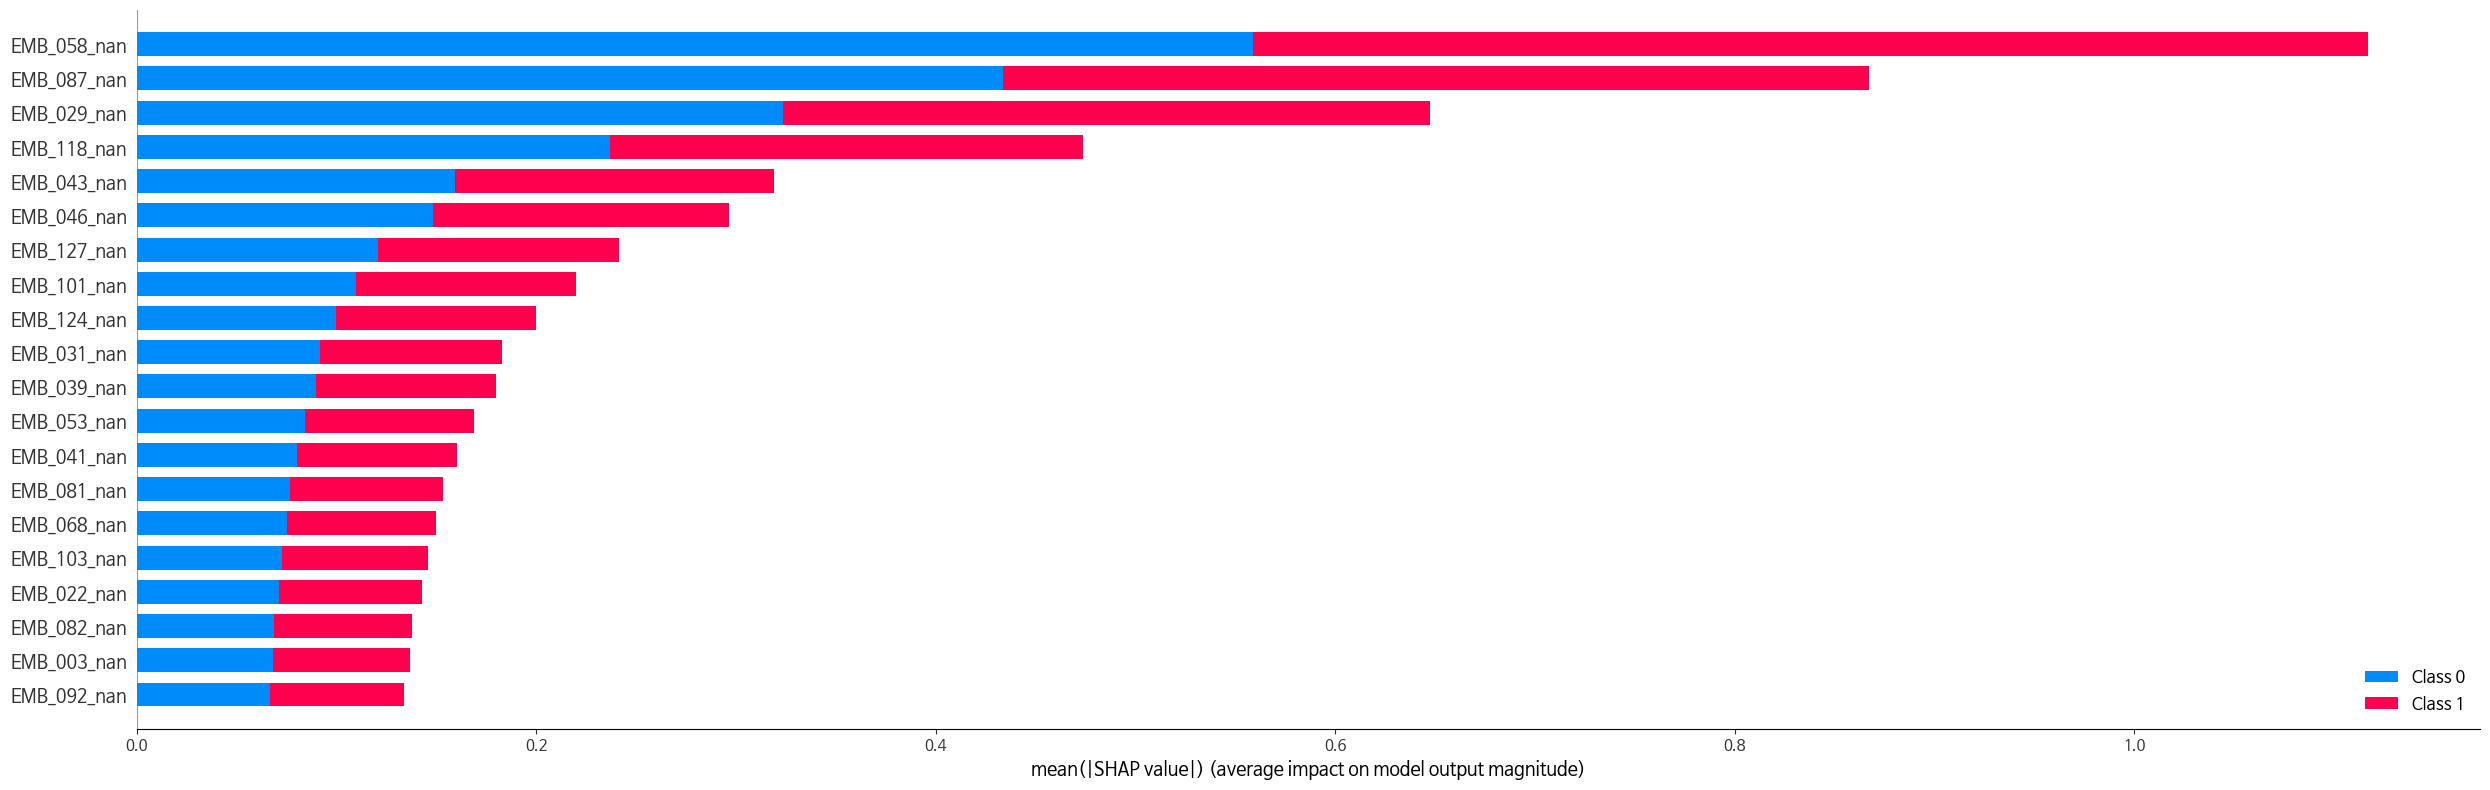

In [23]:
# asset 실행
train2_asset_structure=run(step, pipeline, alo.asset_structure)

# train2 asset의 결과 dataframe은 train2_asset_structure.data['dataframe']으로 확인할 수 있습니다.
train2_asset_structure.data['dataframe'].head(10)

### [5] Output asset  

AI content asset sequence 표준화에 따라 GCR 2.0.0부터는 train 및 output pipeline 모두 input asset으로 시작해 output asset으로 종료하도록 변경되었습니다.   
Output asset은 pipeline의 산출물들을 올바른 위치에 옮겨주는 asset입니다. AI advisor 규약에 따라 내부적으로 미리 지정된 위치를 이용하므로 사용자가 별도로 입력해 줘야 할 parameter는 없습니다.   
<br />

#### 주요 Parameter
- 사용자가 설정해 줘야 할 parameter 없음

#### Parameter 설정

In [24]:
# GCR asset 순서에 따라 step 순서를 입력합니다. (input(0) - readiness(1) - train1(2) - preprocess(3) - train2(4) - output(5))
step = 5
alo.asset_structure = copy.deepcopy(train2_asset_structure)
alo.asset_structure.args = alo.get_args(pipeline, step)

alo.asset_structure.args

{}

#### Output asset 실행 

In [26]:
# asset 실행
output_asset_structure=run(step, pipeline, alo.asset_structure)

# output asset의 결과 dataframe은 output_asset_structure.data['dataframe']으로 확인할 수 있습니다.
output_asset_structure.data['dataframe'].head(10)

[2024-02-16 06:23:56,012][ASSET][INFO][train_pipeline][output]: 

============================= ASSET START =============================
- time (UTC)        : 2024-02-16 06:23:56
- current step      : output
- asset branch.     : output_dev
- alolib ver.       : 2.1
- alo ver.          : 2.1
- load envs. keys   : dict_keys(['project_home', 'solution_metadata_version', 'artifacts', 'alo_version', 'interface_mode', 'proc_start_time', 'save_train_artifacts_path', 'save_inference_artifacts_path', 'pipeline', 'step', 'num_step', 'asset_branch', 'load_data', 'load_config', 'save_data', 'save_config', 'log_file_path', 'prev_step'])
- load args. keys   : dict_keys([])
- load config. keys : dict_keys(['meta', 'data_source_type', 'time_format', 'time_column', 'x_columns', 'input_path', 'group_cnt', 'group_keys', 'y_column', 'input_asset_df_path', 'ignore_columns', 'center_node_column', 'columns_map', 'preprocess'])
- load data keys    : dict_keys(['dataframe'])


[2024-02-16 06:23:56,014][ASSET

,EMB_000_nan,EMB_001_nan,EMB_002_nan,EMB_003_nan,EMB_004_nan,EMB_005_nan,EMB_006_nan,EMB_007_nan,EMB_008_nan,EMB_009_nan,...,EMB_126_nan_shapley,EMB_127_nan_shapley,target_encoded_nan,pred_target_encoded_nan,pred_target_encoded_nan_best0,pred_target_encoded_nan_best1,pred_target_encoded_nan_best2,prob_0,prob_1,train_test
0,-0.074153,-0.055988,-0.052818,0.005892,0.015515,-0.021260,0.026566,0.017620,0.001553,-0.001954,...,0.034957,0.122719,1,1,1,1,1,0.000054,0.999946,1th_test
1,-0.068774,-0.049618,-0.058634,0.009538,0.005547,-0.021479,0.025170,-0.010637,0.005298,0.009066,...,0.006115,-0.162118,1,1,1,1,1,0.011164,0.988836,0th_test
2,-0.033640,-0.032654,-0.017567,0.003200,0.020300,-0.008067,0.017446,0.049978,-0.011376,-0.024331,...,0.017734,0.073409,1,1,1,1,1,0.000445,0.999555,2th_test
3,-0.055558,-0.024381,-0.035403,0.003343,0.007629,-0.023969,0.032309,0.009788,-0.018074,-0.006553,...,-0.000854,0.174334,1,0,0,0,0,0.521614,0.478386,1th_test
4,-0.019305,-0.013052,-0.031120,0.008044,-0.031994,-0.012280,0.001667,-0.081808,0.015399,0.039381,...,-0.009817,-0.097222,0,0,0,0,0,0.606196,0.393804,3th_test
5,0.001473,-0.021499,-0.013175,0.013053,-0.029639,-0.006258,-0.016850,-0.078868,0.014410,0.029548,...,0.005287,0.088159,0,0,0,0,0,0.717698,0.282302,3th_test
6,-0.045707,-0.011426,-0.021226,-0.004355,0.013403,-0.017541,0.031196,0.036596,-0.013267,-0.011521,...,0.050397,-0.216051,1,1,1,1,1,0.014050,0.985950,0th_test
7,-0.060994,-0.010418,-0.041536,0.001866,0.003026,-0.027531,0.046743,0.006817,-0.020207,-0.004573,...,-0.037533,-0.238891,0,1,1,1,1,0.034753,0.965247,2th_test
8,-0.063151,-0.013606,-0.026188,-0.015054,0.031623,-0.023023,0.047041,0.071892,-0.024079,-0.023515,...,0.003898,-0.198318,1,1,1,1,1,0.006411,0.993589,0th_test
9,0.010719,0.022915,-0.000830,0.012984,-0.020518,0.000423,0.004345,-0.043937,-0.001184,0.011903,...,0.074513,0.022036,0,0,0,0,0,0.931072,0.068928,1th_test


## **3. Inference Workflow**

#### GCR의 Inference Workflow 구성은 다음과 같습니다.
> **[0]** Input asset : *사용자가 지정한 경로로부터 데이터를 Import*   
> **[1]** Readiness asset : *Inference 실시 전 입력 데이터의 오류를 검사하여 다음 step을 진행할 지 결정*   
> **[2]** Inference1 asset : *Inference set 데이터를 토대로 그래프를 구성하고 필요한 임베딩 추출*   
> **[3]** Preprocess asset : *(필요시) 결측치 처리 및 라벨 인코딩*   
> **[4]** Inference2 asset : *Train Workflow에서 선택된 베스트 모델을 활용해 라벨 추론*   
> **[5]** Output asset : *추론 결과 생성된 산출물을 올바른 경로에 저장*  

#### Inference Workflow Setup
아래 코드를 실행하여 Inference Workflow에 필요한 라이브러리를 먼저 설치 해주세요.

In [27]:
# 아래는 Inference 시 필요한 라이브러리를 설치하는 코드입니다. library 설치 에러가 발생하면 아래 셀을 재실행 해주세요
alo.external_load_data(pipelines[1]) # external load data for train_pipeline
# 사용하는 pipeline의 package를 설치
# train = 0, infernence = 1을 선택해야 하고 둘다 설치 해야함
pipeline = pipelines[1]
alo.install_steps(pipeline, alo.control["get_asset_source"])
 # 초기 data structure 구성
alo.set_asset_structure()
init_asset_structure = copy.deepcopy(alo.asset_structure)

[2024-02-18 11:46:51,238][PROCESS][WARNING]: You did not write any << s3_private_key_file >> in the config yaml file. When you wanna get data from s3 storage, 
                                 you have to write the s3_private_key_file path or set << AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY >> in your os environment. 

[2024-02-18 11:46:51,359][PROCESS][INFO]: Successfuly removed << /home/jovyan/240216_aicontents_gcr_2.0.0/gcr/alo/input/inference/ >> before loading external data.
[2024-02-18 11:46:51,378][PROCESS][INFO]: << ../../sample_data/test >> may be relative path. The reference folder of relative path is << config/ >>. 
 If this is not appropriate relative path, Loading external data process would raise error.
[2024-02-18 11:46:51,447][PROCESS][INFO]: ==================== Successfully done loading external data: 
 ../../sample_data/test --> /home/jovyan/240216_aicontents_gcr_2.0.0/gcr/alo/input/inference/
[2024-02-18 11:46:51,452][PROCESS][INFO]: Successfuly finish loading << ../

### [0] Input asset 

#### 주요 Parameter
- input_path : GCR에서는 추론데이터가 'inference' 위치에 자동 저장됩니다. 따로 설정할 필요 없이 주어진 'inference'로 놓고 사용합니다.
- x_columns : Inference workflow에서는 x_column을 따로 지정하지 않습니다. None으로 설정합니다.
- use_all_x : Inference workflow에서는 use_all_x를 True로 놓습니다.
- y_column : 추론데이터는 y_column이 없습니다. None으로 설정합니다.
- groupkey_columns : 특정 컬럼 명을 기준으로 데이터를 그룹으로 나누어 모델링을 하고 싶을 경우에 사용합니다.
- drop_columns : use_all_x가 True일 때 삭제하고 싶은 컬럼을 입력합니다.
- time_column : 데이터에 시간 컬럼이 있을 경우 입력합니다.
- concat_dataframes : 같은 형태 csv 파일 여러 개를 input data로 불러올 시, concat 여부를 선택합니다. [*True / False*]
- encoding : pd.read_csv() 시에 사용할 encoding 방법을 설정합니다.

#### Parameter 설정

In [38]:
# GCR asset 순서에 따라 step 순서를 입력합니다. (input(0) - readiness (1) - inference1 (2) - preprocess(3) - inference2(4) - output(5))
step = 0 
alo.asset_structure = copy.deepcopy(init_asset_structure)
alo.asset_structure.args = alo.get_args(pipeline, step)

# 아래 주석을 풀어 input asset argument를 원하는 값으로 수정합니다.
# asset_structure.args['x_columns'] = ['']
alo.asset_structure.args

{'input_path': 'test',
 'x_columns': None,
 'use_all_x': True,
 'y_column': None,
 'groupkey_columns': None,
 'drop_columns': None,
 'time_column': None,
 'concat_dataframes': None,
 'encoding': None}

##### Input asset 실행 

In [39]:
# asset 실행
input_asset_structure=run(step, pipeline, alo.asset_structure)

# input asset의 결과 dataframe은 input_asset_structure.data['dataframe']으로 확인할 수 있습니다.
input_asset_structure.data['dataframe'].head(10)

[2024-02-18 12:37:07,720][USER][INFO][inference_pipeline][input]: >> Load path : ['/home/jovyan/240216_aicontents_gcr_2.0.0/gcr/alo/input/inference/test/']
[2024-02-18 12:37:07,766][USER][INFO][inference_pipeline][input]: >> The file for batch data has been loaded. (File name: /home/jovyan/240216_aicontents_gcr_2.0.0/gcr/alo/input/inference/test/inference.csv)
[2024-02-18 12:37:07,771][USER][INFO][inference_pipeline][input]: You set the << use_all_x >> as << True >> in the yaml file. So skip checking dataframe columns existence.
[2024-02-18 12:37:07,776][USER][INFO][inference_pipeline][input]: ==================== Success loading dataframe ====================
[2024-02-18 12:37:07,780][USER][INFO][inference_pipeline][input]: >> Start processing ignore columns & drop columns: ['/home/jovyan/240216_aicontents_gcr_2.0.0/gcr/alo/input/inference/test/inference.csv']
[2024-02-18 12:37:07,787][USER][INFO][inference_pipeline][input]: >> You set the << use_all_x >> parameter as << True >> in yo

[2024-02-18 12:37:07,694][ASSET][INFO][inference_pipeline][input]: 

============================= ASSET START =============================
- time (UTC)        : 2024-02-18 12:37:07
- current step      : input
- asset branch.     : tabular_2.0
- alolib ver.       : 2.1
- alo ver.          : 2.1
- load envs. keys   : dict_keys(['project_home', 'solution_metadata_version', 'artifacts', 'alo_version', 'interface_mode', 'proc_start_time', 'save_train_artifacts_path', 'save_inference_artifacts_path', 'pipeline', 'step', 'num_step', 'asset_branch', 'load_data', 'load_config', 'save_data', 'save_config', 'log_file_path'])
- load args. keys   : dict_keys(['input_path', 'x_columns', 'use_all_x', 'y_column', 'groupkey_columns', 'drop_columns', 'time_column', 'concat_dataframes', 'encoding'])
- load config. keys : dict_keys(['meta'])
- load data keys    : dict_keys([])


[2024-02-18 12:37:07,788][ASSET][INFO][inference_pipeline][input]: 

============================= ASSET FINISH ==============

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,ID
0,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,CX7
1,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,CX8
2,32,Private,205019,Assoc-acdm,12,Never-married,Sales,Not-in-family,Black,Male,0,0,50,United-States,CX13
3,32,Private,186824,HS-grad,9,Never-married,Machine-op-inspct,Unmarried,White,Male,0,0,40,United-States,CX17
4,43,Self-emp-not-inc,292175,Masters,14,Divorced,Exec-managerial,Unmarried,White,Female,0,0,45,United-States,CX19
5,40,Private,193524,Doctorate,16,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,60,United-States,CX20
6,54,?,180211,Some-college,10,Married-civ-spouse,?,Husband,Asian-Pac-Islander,Male,0,0,60,South,CX27
7,31,Private,84154,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,38,?,CX38
8,47,Private,51835,Prof-school,15,Married-civ-spouse,Prof-specialty,Wife,White,Female,0,1902,60,Honduras,CX52
9,28,Private,183175,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,CX66


### [1] Readiness asset

#### 주요 Parameter   
<br />
GCR 2.0.0부터는 data readiness check을 수행하기 위한 readiness asset이 추가되었습니다.   
<br />
Readiness asset은 AI content 마다 수행하는 기능과 parameter들이 상이한데, 이는 각 AI content의 동작에 맞도록 input data의 오류를 검사하기 때문입니다.   
Input data에서 오류가 발견된 경우, readiness asset은 error를 발생시켜 전체 pipeline을 멈추게 됩니다. 이 때, 발생된 error는 log file에서 확인하실 수 있습니다.   
<br />
GCR의 readiness asset은 label에 해당하는 column에 결측치가 있는지, graph의 center node에 해당하는 column에 결측치가 있는지를 확인합니다. 
<br />  
이를 위해 필요한 parameter들이 아래와 같습니다.   
<br />
현재 readiness asset이 alpha version인 관계로, 다른 asset과 parameter 중복이 존재하는데, 이 문제는 readiness asset 정식 version이 release되는 시점 (24년 3월)에 정리될 예정이오니 양해 부탁 드립니다.   
<br />

- ***x_columns*** : 데이터의 모든 컬럼을 활용하지 않는 경우엔 직접 선택해서 사용할 수 있습니다.
- ***y_column*** : Classification, Regression을 위해서는 Label이 있어야 합니다. Label에 해당하는 컬럼을 작성합니다.
- ***groupkey_columns*** : 특정 컬럼 명을 기준으로 데이터를 그룹으로 나누어 모델링을 하고 싶을 경우에 사용합니다.
- ***center_node_column*** : 특정 컬럼 명을 기준으로 데이터를 그룹으로 나누어 모델링을 하고 싶을 경우에 사용합니다.


#### Parameter 설정

In [40]:
# GCR asset 순서에 따라 step 순서를 입력합니다. (input(0) - readiness(1) - train1(2) - preprocess(3) - train2(4) - output(5))
step = 1
alo.asset_structure= copy.deepcopy(input_asset_structure)
alo.asset_structure.args = alo.get_args(pipeline, step)

# 아래 주석을 풀어 input asset argument를 원하는 값으로 수정합니다. 
#asset_structure.args['x_columns'] = ['']
alo.asset_structure.args

{'x_columns': None,
 'y_column': 'target',
 'groupkey_columns': None,
 'center_node_column': 'ID'}

#### Readiness asset 실행 

In [41]:
readiness_asset_structure = run(step, pipeline, alo.asset_structure)

# Readiness asset의 결과 dataframe은 readiness_asset_structure.data['dataframe']으로 확인할 수 있습니다.
readiness_asset_structure.data['dataframe'].head(10)

[2024-02-18 12:37:27,456][ASSET][INFO][inference_pipeline][readiness]: 

============================= ASSET START =============================
- time (UTC)        : 2024-02-18 12:37:27
- current step      : readiness
- asset branch.     : gcr-0.9.0
- alolib ver.       : 2.1
- alo ver.          : 2.1
- load envs. keys   : dict_keys(['project_home', 'solution_metadata_version', 'artifacts', 'alo_version', 'interface_mode', 'proc_start_time', 'save_train_artifacts_path', 'save_inference_artifacts_path', 'pipeline', 'step', 'num_step', 'asset_branch', 'load_data', 'load_config', 'save_data', 'save_config', 'log_file_path', 'prev_step'])
- load args. keys   : dict_keys(['x_columns', 'y_column', 'groupkey_columns', 'center_node_column'])
- load config. keys : dict_keys(['meta', 'data_source_type', 'time_format', 'time_column', 'x_columns', 'input_path', 'group_cnt', 'group_keys', 'y_column', 'input_asset_df_path', 'ignore_columns'])
- load data keys    : dict_keys(['dataframe'])


In __ini

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,ID
0,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,CX7
1,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,CX8
2,32,Private,205019,Assoc-acdm,12,Never-married,Sales,Not-in-family,Black,Male,0,0,50,United-States,CX13
3,32,Private,186824,HS-grad,9,Never-married,Machine-op-inspct,Unmarried,White,Male,0,0,40,United-States,CX17
4,43,Self-emp-not-inc,292175,Masters,14,Divorced,Exec-managerial,Unmarried,White,Female,0,0,45,United-States,CX19
5,40,Private,193524,Doctorate,16,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,60,United-States,CX20
6,54,?,180211,Some-college,10,Married-civ-spouse,?,Husband,Asian-Pac-Islander,Male,0,0,60,South,CX27
7,31,Private,84154,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,38,?,CX38
8,47,Private,51835,Prof-school,15,Married-civ-spouse,Prof-specialty,Wife,White,Female,0,1902,60,Honduras,CX52
9,28,Private,183175,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,CX66


### [2] Inference1 asset 

GCR 2.0.0부터 inductive graph embedding을 지원함에 따라, inference pipeline에 inference1 asset이 추가되었습니다.   
즉, 기존에는 train set과 inference set을 합쳐 train set에서 graph embedding이 이루어졌고, 그로 인해 inference set이 바뀔 때 마다 train pipeline의 재수행이 필요했으나, GCR 2.0.0부터는 inference set이 바뀌어도 해당 inference set에 대해서만 새로운 graph embedding이 이루어지므로 더 이상 train pipeline의 재수행이 필요하지 않습니다.   
<br />
Graph embedding parameter 설정은 train 시의 설정을 동일하게 유지하므로, inference pipeline에서 고객이 추가로 입력해야 할 parameters는 없습니다.   

#### 주요 Parameter
- 없음

#### Parameter 설정

In [42]:
# GCR asset 순서에 따라 step 순서를 입력합니다. (input(0) - readiness (1) - inference1 (2) - preprocess(3) - inference2(4) - output(5))
step = 2 
alo.asset_structure = copy.deepcopy(readiness_asset_structure)
alo.asset_structure.args = alo.get_args(pipeline, step)

# 아래 주석을 풀어 inference1 asset argument를 원하는 값으로 수정합니다.
# asset_structure.args['x_columns'] = ['']
alo.asset_structure.args

{}

#### Inference1 asset 실행 

In [43]:
# asset 실행
inference1_asset_structure=run(step, pipeline, alo.asset_structure)

# inference1 asset의 결과 dataframe은 inference1_asset_structure.data['dataframe']으로 확인할 수 있습니다.  
inference1_asset_structure.data['dataframe'].head(10)

[2024-02-18 12:38:21,558][ASSET][INFO][inference_pipeline][inference1]: Successfully got model path for saving or loading your AI model: 
 /home/jovyan/240216_aicontents_gcr_2.0.0/gcr/alo/.train_artifacts/models/train/
[2024-02-18 12:38:21,561][ASSET][INFO][inference_pipeline][inference1]: 

============================= ASSET START =============================
- time (UTC)        : 2024-02-18 12:38:21
- current step      : inference1
- asset branch.     : develop
- alolib ver.       : 2.1
- alo ver.          : 2.1
- load envs. keys   : dict_keys(['project_home', 'solution_metadata_version', 'artifacts', 'alo_version', 'interface_mode', 'proc_start_time', 'save_train_artifacts_path', 'save_inference_artifacts_path', 'pipeline', 'step', 'num_step', 'asset_branch', 'load_data', 'load_config', 'save_data', 'save_config', 'log_file_path', 'prev_step'])
- load args. keys   : dict_keys([])
- load config. keys : dict_keys(['meta', 'data_source_type', 'time_format', 'time_column', 'x_columns'

,EMB_000,EMB_001,EMB_002,EMB_003,EMB_004,EMB_005,EMB_006,EMB_007,EMB_008,EMB_009,...,EMB_118,EMB_119,EMB_120,EMB_121,EMB_122,EMB_123,EMB_124,EMB_125,EMB_126,EMB_127
0,-0.006582,-0.030715,-0.033298,0.016711,-0.040304,-0.005820,-0.021985,-0.121384,0.036542,0.057989,...,-0.007409,-0.030868,0.021985,0.022022,-0.016511,-0.026778,0.005259,-0.069812,0.046847,-0.005185
1,-0.036613,0.010367,-0.022862,0.006432,-0.006352,-0.018229,0.041738,0.000693,-0.023588,-0.007744,...,0.016406,-0.008161,-0.003214,-0.011097,-0.014743,0.025421,0.005437,-0.016584,-0.010947,0.010507
2,-0.035223,-0.008997,-0.017698,-0.005772,0.007104,-0.015288,0.020383,0.018882,-0.012446,-0.004120,...,0.003257,-0.002660,-0.003339,0.000454,-0.011902,0.024652,0.004940,0.005467,0.002907,0.006057
3,-0.060184,-0.048973,-0.050838,0.003790,0.006609,-0.016322,0.014977,-0.005287,0.010419,0.010205,...,-0.012011,-0.016546,-0.010955,0.019603,-0.028964,0.026093,0.008958,-0.007763,0.043811,-0.002461
4,-0.022729,0.017269,-0.014061,0.002197,-0.012464,-0.016102,0.032073,-0.019775,-0.012860,0.006835,...,0.017718,-0.010954,0.005000,-0.009872,-0.010527,0.016775,0.006311,-0.035626,-0.004673,0.007754
5,-0.000686,-0.009225,-0.024240,0.028939,-0.040605,-0.002884,-0.008143,-0.104462,0.008309,0.030034,...,0.003498,-0.025845,0.008858,0.008207,-0.005420,-0.020894,0.003838,-0.056699,0.004441,0.004468
6,0.001991,-0.020987,-0.000745,0.009669,-0.020101,0.001262,-0.004256,-0.037489,0.006000,0.012287,...,-0.004033,-0.011041,0.003463,0.010135,-0.011195,-0.016009,-0.001493,-0.029278,0.022887,-0.006947
7,-0.048608,-0.041733,-0.051635,0.018432,-0.013950,-0.022629,0.013912,-0.053893,-0.002898,0.014815,...,-0.004983,-0.023749,-0.006918,0.017776,-0.029375,0.011014,0.013531,-0.033731,0.029080,0.001374
8,0.007821,0.013841,-0.006246,0.020809,-0.026219,-0.004054,0.004046,-0.059275,-0.009186,0.007548,...,0.011782,-0.011115,0.001337,-0.006339,0.002769,-0.008935,0.006211,-0.037140,-0.015952,0.007983
9,-0.099372,-0.035823,-0.051990,-0.008933,0.030894,-0.034492,0.063822,0.069110,-0.029069,-0.023238,...,-0.001302,-0.006837,-0.027847,0.008006,-0.043292,0.064878,0.013081,0.014527,0.025030,0.001513


### [3] Preprocess asset 

GCR은 데이터 전처리가 불필요하기 때문에 Preprocess asset의 역할은 크지 않습니다. 다만 사용자가 임베딩 외에 raw data를 학습에 사용하는 경우 (즉, extra_columns_for_ml 설정시) 결측치를 처리하기 위한 용도입니다.
#### 주요 Parameter
- handling_missing: 결측치 처리 방식을 지정합니다. 'interpolation' 또는 'fill_number' 중에 선택할 수 있으며 GCR에서는 'interpolation'을 권장합니다.
- ***handling_encoding_y_column***: None으로 설정합니다.
- limit_encoding_categories: onehot이나 hashing 인코딩 진행 시 컬럼이 너무 많아지는 것에 대한 한계치를 설정합니다.
- load_train_preprocess: 반드시 True로 설정합니다. train workflow의 preprocess를 참조하여 진행합니다.

#### Parameter 설정

In [44]:
# GCR asset 순서에 따라 step 순서를 입력합니다. (input(0) - readiness (1) - inference1 (2) - preprocess(3) - inference2(4) - output(5))
step = 3 
alo.asset_structure = copy.deepcopy(inference1_asset_structure)
alo.asset_structure.args = alo.get_args(pipeline, step)

# 아래 주석을 풀어 preprocess asset argument를 원하는 값으로 수정합니다.
# asset_structure.args['x_columns'] = ['']
alo.asset_structure.args

{'handling_missing': 'interpolation',
 'handling_encoding_y_column': None,
 'limit_encoding_categories': 30,
 'load_train_preprocess': True}

#### Preprocess asset 실행 

In [45]:
# asset 실행
preprocess_asset_structure=run(step, pipeline, alo.asset_structure)

# preprocess asset의 결과 dataframe은 preprocess_asset_structure.data['dataframe']으로 확인할 수 있습니다.  
preprocess_asset_structure.data['dataframe'].head(10)

[2024-02-18 12:39:08,577][ASSET][INFO][inference_pipeline][preprocess]: Successfully got model path for saving or loading your AI model: 
 /home/jovyan/240216_aicontents_gcr_2.0.0/gcr/alo/.train_artifacts/models/preprocess/
[2024-02-18 12:39:08,580][ASSET][INFO][inference_pipeline][preprocess]: 

============================= ASSET START =============================
- time (UTC)        : 2024-02-18 12:39:08
- current step      : preprocess
- asset branch.     : release-1.2
- alolib ver.       : 2.1
- alo ver.          : 2.1
- load envs. keys   : dict_keys(['project_home', 'solution_metadata_version', 'artifacts', 'alo_version', 'interface_mode', 'proc_start_time', 'save_train_artifacts_path', 'save_inference_artifacts_path', 'pipeline', 'step', 'num_step', 'asset_branch', 'load_data', 'load_config', 'save_data', 'save_config', 'log_file_path', 'prev_step'])
- load args. keys   : dict_keys(['handling_missing', 'handling_encoding_y_column', 'limit_encoding_categories', 'load_train_prepr

,EMB_000,EMB_001,EMB_002,EMB_003,EMB_004,EMB_005,EMB_006,EMB_007,EMB_008,EMB_009,...,EMB_118_nan,EMB_119_nan,EMB_120_nan,EMB_121_nan,EMB_122_nan,EMB_123_nan,EMB_124_nan,EMB_125_nan,EMB_126_nan,EMB_127_nan
0,-0.006582,-0.030715,-0.033298,0.016711,-0.040304,-0.005820,-0.021985,-0.121384,0.036542,0.057989,...,-0.007409,-0.030868,0.021985,0.022022,-0.016511,-0.026778,0.005259,-0.069812,0.046847,-0.005185
1,-0.036613,0.010367,-0.022862,0.006432,-0.006352,-0.018229,0.041738,0.000693,-0.023588,-0.007744,...,0.016406,-0.008161,-0.003214,-0.011097,-0.014743,0.025421,0.005437,-0.016584,-0.010947,0.010507
2,-0.035223,-0.008997,-0.017698,-0.005772,0.007104,-0.015288,0.020383,0.018882,-0.012446,-0.004120,...,0.003257,-0.002660,-0.003339,0.000454,-0.011902,0.024652,0.004940,0.005467,0.002907,0.006057
3,-0.060184,-0.048973,-0.050838,0.003790,0.006609,-0.016322,0.014977,-0.005287,0.010419,0.010205,...,-0.012011,-0.016546,-0.010955,0.019603,-0.028964,0.026093,0.008958,-0.007763,0.043811,-0.002461
4,-0.022729,0.017269,-0.014061,0.002197,-0.012464,-0.016102,0.032073,-0.019775,-0.012860,0.006835,...,0.017718,-0.010954,0.005000,-0.009872,-0.010527,0.016775,0.006311,-0.035626,-0.004673,0.007754
5,-0.000686,-0.009225,-0.024240,0.028939,-0.040605,-0.002884,-0.008143,-0.104462,0.008309,0.030034,...,0.003498,-0.025845,0.008858,0.008207,-0.005420,-0.020894,0.003838,-0.056699,0.004441,0.004468
6,0.001991,-0.020987,-0.000745,0.009669,-0.020101,0.001262,-0.004256,-0.037489,0.006000,0.012287,...,-0.004033,-0.011041,0.003463,0.010135,-0.011195,-0.016009,-0.001493,-0.029278,0.022887,-0.006947
7,-0.048608,-0.041733,-0.051635,0.018432,-0.013950,-0.022629,0.013912,-0.053893,-0.002898,0.014815,...,-0.004983,-0.023749,-0.006918,0.017776,-0.029375,0.011014,0.013531,-0.033731,0.029080,0.001374
8,0.007821,0.013841,-0.006246,0.020809,-0.026219,-0.004054,0.004046,-0.059275,-0.009186,0.007548,...,0.011782,-0.011115,0.001337,-0.006339,0.002769,-0.008935,0.006211,-0.037140,-0.015952,0.007983
9,-0.099372,-0.035823,-0.051990,-0.008933,0.030894,-0.034492,0.063822,0.069110,-0.029069,-0.023238,...,-0.001302,-0.006837,-0.027847,0.008006,-0.043292,0.064878,0.013081,0.014527,0.025030,0.001513


### [4] Inference2 asset 

GCR 2.0.0부터 inductive ML이 지원됨에 따라 inference pipeline도 graph embedding asset (inference1 asset)이 포함되므로, classification 및 regression을 위한 기존의 inference asset이 inference2 asset으로 이름 변경되었습니다.

#### 주요 Parameter
- model_type: Train workflow의 Train asset과 동일하게 classification/regression 중 설정하면 됩니다. [*classification / regression*]
- run_shapley: shapley 실행 여부를 선택합니다. [*True / False*]

#### Parameter 설정

In [46]:
# GCR asset 순서에 따라 step 순서를 입력합니다. (input(0) - readiness (1) - inference1 (2) - preprocess(3) - inference2(4) - output(5))
step = 4 
alo.asset_structure = copy.deepcopy(preprocess_asset_structure)
alo.asset_structure.args = alo.get_args(pipeline, step)

# 아래 주석을 풀어 inference asset argument를 원하는 값으로 수정합니다.
# asset_structure.args['x_columns'] = ['']
alo.asset_structure.args

{'model_type': 'classification', 'run_shapley': False}

#### Inference2 asset 실행 

In [47]:
# asset 실행
inference2_asset_structure=run(step, pipeline, alo.asset_structure)

# inference2 asset의 결과 dataframe은 inference2_asset_structure.data['dataframe']으로 확인할 수 있습니다.  
inference2_asset_structure.data['dataframe'].head(10)

font: ['NanumBarunGothic']

 ################################### inference_init (sec):  0.00021457672119140625 ################################### 

[2024-02-18 12:42:33,751][ASSET][INFO][inference_pipeline][inference2]: 

============================= ASSET START =============================
- time (UTC)        : 2024-02-18 12:42:33
- current step      : inference2
- asset branch.     : tcr_v1.1.4
- alolib ver.       : 2.1
- alo ver.          : 2.1
- load envs. keys   : dict_keys(['project_home', 'solution_metadata_version', 'artifacts', 'alo_version', 'interface_mode', 'proc_start_time', 'save_train_artifacts_path', 'save_inference_artifacts_path', 'pipeline', 'step', 'num_step', 'asset_branch', 'load_data', 'load_config', 'save_data', 'save_config', 'log_file_path', 'prev_step'])
- load args. keys   : dict_keys(['model_type', 'run_shapley'])
- load config. keys : dict_keys(['meta', 'data_source_type', 'time_format', 'time_column', 'x_columns', 'input_path', 'group_cnt', 'group_keys

,EMB_000,EMB_001,EMB_002,EMB_003,EMB_004,EMB_005,EMB_006,EMB_007,EMB_008,EMB_009,...,EMB_123_nan,EMB_124_nan,EMB_125_nan,EMB_126_nan,EMB_127_nan,train_test,pred_,prediction_score,prob_0,prob_1
0,-0.006582,-0.030715,-0.033298,0.016711,-0.040304,-0.005820,-0.021985,-0.121384,0.036542,0.057989,...,-0.026778,0.005259,-0.069812,0.046847,-0.005185,test,0,"[0.5150744928098547, 0.4849255071901452]",0.515074,0.484926
1,-0.036613,0.010367,-0.022862,0.006432,-0.006352,-0.018229,0.041738,0.000693,-0.023588,-0.007744,...,0.025421,0.005437,-0.016584,-0.010947,0.010507,test,1,"[0.4839683381813784, 0.5160316618186216]",0.483968,0.516032
2,-0.035223,-0.008997,-0.017698,-0.005772,0.007104,-0.015288,0.020383,0.018882,-0.012446,-0.004120,...,0.024652,0.004940,0.005467,0.002907,0.006057,test,1,"[0.18866384155711147, 0.8113361584428885]",0.188664,0.811336
3,-0.060184,-0.048973,-0.050838,0.003790,0.006609,-0.016322,0.014977,-0.005287,0.010419,0.010205,...,0.026093,0.008958,-0.007763,0.043811,-0.002461,test,1,"[0.0034548822989322048, 0.9965451177010678]",0.003455,0.996545
4,-0.022729,0.017269,-0.014061,0.002197,-0.012464,-0.016102,0.032073,-0.019775,-0.012860,0.006835,...,0.016775,0.006311,-0.035626,-0.004673,0.007754,test,0,"[0.6471172289045981, 0.35288277109540195]",0.647117,0.352883
5,-0.000686,-0.009225,-0.024240,0.028939,-0.040605,-0.002884,-0.008143,-0.104462,0.008309,0.030034,...,-0.020894,0.003838,-0.056699,0.004441,0.004468,test,0,"[0.7347797741003542, 0.2652202258996458]",0.734780,0.265220
6,0.001991,-0.020987,-0.000745,0.009669,-0.020101,0.001262,-0.004256,-0.037489,0.006000,0.012287,...,-0.016009,-0.001493,-0.029278,0.022887,-0.006947,test,0,"[0.6103225519052327, 0.3896774480947674]",0.610323,0.389677
7,-0.048608,-0.041733,-0.051635,0.018432,-0.013950,-0.022629,0.013912,-0.053893,-0.002898,0.014815,...,0.011014,0.013531,-0.033731,0.029080,0.001374,test,1,"[0.2262415791488076, 0.7737584208511924]",0.226242,0.773758
8,0.007821,0.013841,-0.006246,0.020809,-0.026219,-0.004054,0.004046,-0.059275,-0.009186,0.007548,...,-0.008935,0.006211,-0.037140,-0.015952,0.007983,test,0,"[0.7995174698140237, 0.20048253018597628]",0.799517,0.200483
9,-0.099372,-0.035823,-0.051990,-0.008933,0.030894,-0.034492,0.063822,0.069110,-0.029069,-0.023238,...,0.064878,0.013081,0.014527,0.025030,0.001513,test,1,"[0.0044173301105442375, 0.9955826698894558]",0.004417,0.995583


### [5] Output asset

AI content asset sequence 표준화에 따라 GCR 2.0.0부터는 train 및 output pipeline 모두 input asset으로 시작해 output asset으로 종료하도록 변경되었습니다.   
Output asset은 pipeline의 산출물들을 올바른 위치에 옮겨주는 asset입니다. AI advisor 규약에 따라 내부적으로 미리 지정된 위치를 이용하므로 사용자가 별도로 입력해 줘야 할 parameter는 없습니다.   
<br />

#### 주요 Parameter
* 사용자가 설정해 줘야 할 parameter 없음

#### Parameter 설정

In [48]:
# GCR asset 순서에 따라 step 순서를 입력합니다. (input(0) - readiness (1) - inference1 (2) - preprocess(3) - inference2(4) - output(5))
step = 5
alo.asset_structure = copy.deepcopy(inference2_asset_structure)
alo.asset_structure.args = alo.get_args(pipeline, step)

# 아래 주석을 풀어 result asset argument를 원하는 값으로 수정합니다.
# asset_structure.args['x_columns'] = ['']
alo.asset_structure.args

{}

#### Output asset 실행 

In [49]:
# asset 실행
output_asset_structure=run(step, pipeline, alo.asset_structure)

# output asset의 결과 dataframe은 output_asset_structure.data['dataframe']으로 확인할 수 있습니다.
output_asset_structure.data['dataframe'].head(10)

[2024-02-18 12:47:42,316][ASSET][INFO][inference_pipeline][output]: 

============================= ASSET START =============================
- time (UTC)        : 2024-02-18 12:47:42
- current step      : output
- asset branch.     : output_dev
- alolib ver.       : 2.1
- alo ver.          : 2.1
- load envs. keys   : dict_keys(['project_home', 'solution_metadata_version', 'artifacts', 'alo_version', 'interface_mode', 'proc_start_time', 'save_train_artifacts_path', 'save_inference_artifacts_path', 'pipeline', 'step', 'num_step', 'asset_branch', 'load_data', 'load_config', 'save_data', 'save_config', 'log_file_path', 'prev_step'])
- load args. keys   : dict_keys([])
- load config. keys : dict_keys(['meta', 'data_source_type', 'time_format', 'time_column', 'x_columns', 'input_path', 'group_cnt', 'group_keys', 'y_column', 'input_asset_df_path', 'ignore_columns', 'center_node_column', 'embedding_column', 'dataframe_org', 'columns_map', 'preprocess'])
- load data keys    : dict_keys(['dataf

,EMB_000,EMB_001,EMB_002,EMB_003,EMB_004,EMB_005,EMB_006,EMB_007,EMB_008,EMB_009,...,EMB_123_nan,EMB_124_nan,EMB_125_nan,EMB_126_nan,EMB_127_nan,train_test,pred_,prediction_score,prob_0,prob_1
0,-0.006582,-0.030715,-0.033298,0.016711,-0.040304,-0.005820,-0.021985,-0.121384,0.036542,0.057989,...,-0.026778,0.005259,-0.069812,0.046847,-0.005185,test,0,"[0.5150744928098547, 0.4849255071901452]",0.515074,0.484926
1,-0.036613,0.010367,-0.022862,0.006432,-0.006352,-0.018229,0.041738,0.000693,-0.023588,-0.007744,...,0.025421,0.005437,-0.016584,-0.010947,0.010507,test,1,"[0.4839683381813784, 0.5160316618186216]",0.483968,0.516032
2,-0.035223,-0.008997,-0.017698,-0.005772,0.007104,-0.015288,0.020383,0.018882,-0.012446,-0.004120,...,0.024652,0.004940,0.005467,0.002907,0.006057,test,1,"[0.18866384155711147, 0.8113361584428885]",0.188664,0.811336
3,-0.060184,-0.048973,-0.050838,0.003790,0.006609,-0.016322,0.014977,-0.005287,0.010419,0.010205,...,0.026093,0.008958,-0.007763,0.043811,-0.002461,test,1,"[0.0034548822989322048, 0.9965451177010678]",0.003455,0.996545
4,-0.022729,0.017269,-0.014061,0.002197,-0.012464,-0.016102,0.032073,-0.019775,-0.012860,0.006835,...,0.016775,0.006311,-0.035626,-0.004673,0.007754,test,0,"[0.6471172289045981, 0.35288277109540195]",0.647117,0.352883
5,-0.000686,-0.009225,-0.024240,0.028939,-0.040605,-0.002884,-0.008143,-0.104462,0.008309,0.030034,...,-0.020894,0.003838,-0.056699,0.004441,0.004468,test,0,"[0.7347797741003542, 0.2652202258996458]",0.734780,0.265220
6,0.001991,-0.020987,-0.000745,0.009669,-0.020101,0.001262,-0.004256,-0.037489,0.006000,0.012287,...,-0.016009,-0.001493,-0.029278,0.022887,-0.006947,test,0,"[0.6103225519052327, 0.3896774480947674]",0.610323,0.389677
7,-0.048608,-0.041733,-0.051635,0.018432,-0.013950,-0.022629,0.013912,-0.053893,-0.002898,0.014815,...,0.011014,0.013531,-0.033731,0.029080,0.001374,test,1,"[0.2262415791488076, 0.7737584208511924]",0.226242,0.773758
8,0.007821,0.013841,-0.006246,0.020809,-0.026219,-0.004054,0.004046,-0.059275,-0.009186,0.007548,...,-0.008935,0.006211,-0.037140,-0.015952,0.007983,test,0,"[0.7995174698140237, 0.20048253018597628]",0.799517,0.200483
9,-0.099372,-0.035823,-0.051990,-0.008933,0.030894,-0.034492,0.063822,0.069110,-0.029069,-0.023238,...,0.064878,0.013081,0.014527,0.025030,0.001513,test,1,"[0.0044173301105442375, 0.9955826698894558]",0.004417,0.995583


## **4. Batch Running**

Asset 단위가 아닌 전체 workflows에 대해 한번에 동작 시킬 수 있습니다.   
<br />

*Sample Notebook에서 반영한 parameter는 experimental_plan.yaml에 반영되지 않습니다.*   
*config/experimental_plan.yaml을 직접 수정하여 사용하시길 바랍니다.*   
<br />

***NOTE!***
<br />
ALO 2.1 기준으로 설명된 이전 chapter들과 달리, batch running chapter에서는 ALO 2.2 기준 사용법을 설명합니다.  
ALO 2.1과 2.2는 설치 방법과 환경 설정이 다르므로, batch running 시에는 sample notebook을 위해 설치한 개발 환경을 이용할 수 없으므로, 아래 guide에 따라 별도의 개발 환경을 준비해 주시기 바랍니다.
<br />

### 4.1. 데이터 준비

#### GCR을 사용하기 위해서는 아래와 같은 방법으로 데이터를 준비해야 합니다.
> 1. Train, Inference 두 개의 데이터셋을 준비합니다. 본 notebook에서는 GCR 설치 시 함께 제공되는 default sample data를 이용합니다.  
> 2. GCR은 supervised learning을 제공하는 AI content이므로 train set에는 label에 해당하는 column이 존재해야 합니다. 또한, label에 해당하는 column은 결측치가 있어서는 안됩니다.
> 3. Train set과 inference set은 label column을 제외하면 column명 list가 일치해야 합니다.
> 4. Graph 구성을 위해 사용자가 지정해줘야 할 center node column ('center_node_column')도 결측치가 있어서는 안됩니다.   

***GCR은 Graph-powered ML을 제공하므로, label 및 center node columns 외의 column들에 대해서는 결측치에 대한 전처리가 불필요하며, 모든 columns에 대해 범주형 데이터에 대한 전처리도 필요하지 않습니다***   
<br />

### 4.2. ALO와 GCR AI content 설치

아래와 같이 ALO와 GCR AI content를 설치하여 개발 환경을 준비합니다.   
<br />

+ ***먼저 ALO를 설치합니다.***    
<br />

이 때, 사용할 GCR version에 맞는 ALO version 설치가 필요합니다.   
본 sample notebook에서는 2024년 2월 현재 최신 GCR version인 2.0.0을 다루고 있으므로, 거기에 맞는 ALO version 2.2를 설치합니다.   
GCR version과 ALO version 간 mapping 정보는 http://collab.lge.com/main/pages/viewpage.action?pageId=2338397990의 guide를 참고해 주십시오.
<br />

작업 directory를 준비합니다 (여기에서는 예를 들어 aisolution_gcr_2.0.0이라는 directory를 생성합니다).   
<br />

\\$ mkdir aisolution_gcr_2.0.0   
\\$ cd aisolution_gcr_2.0.0   
<br />

AI solution name을 예를 들어 gcr_solution으로 하여 ALO를 설치합니다.   
<br />

\\$ git clone http://mod.lge.com/hub/dxadvtech/aicontents-framework/alo.git -b release-2.2 gcr_solution   
\\$ cd gcr_solution   
<br />

gcr_solution이라는 AI solution 개발을 위한 가상환경을 만들어 줍니다.   
이미 어떤 가상환경에 진입한 상태라면, conda deactivate를 수행해 해당 환경에서 빠져나간 뒤 수행해 주십시오.   
<br />

\\$ conda create -n gcr_solution python=3.10  => 3.10 필수   
\\$ conda init bash   
\\$ source ~/.bashrc => 이 명령은 아래 conda activate gcr_solution을 바로 수행했을 때 동작하지 않는 경우에만 수행해 주십시오.   
\\$ conda activate gcr_solution   
\\$ pip install -r requirements.txt   
<br />

+ ***ALO 설치가 완료되었으면, GCR 2.0.0을 설치합니다.***   
<br />

\\$ git clone http://mod.lge.com/hub/dxadvtech/aicontents/gcr.git solution   
<br />

GCR version 2.0.0이 올바로 설치되었는지 확인합니다.   
<br />

\\$ cd solution   
\\$ git status => 결과가 'On branch release-2.0.0'이 맞는 지 확인합니다.   
<br />

만일 다른 version이 설치되었다면, release-2.0.0을 다시 설치합니다.   
<br />

\\$ cd ..   
\\$ \rm -rf solution   
\\$ git clone -b release-2.0.0 --single-branch http://mod.lge.com/hub/dxadvtech/aicontents/gcr.git solution   
<br />

Default로 제공되는 sample data 대신 다른 data를 이용하려면 아래와 같이 experimental_plan.yaml을 수정합니다.   
<br />

\\$ vi aisolution_gcr_2.0.0/gcr_solution/solution/experimental_plan.yaml   
<br />

external_path의 load_train_data_path에 아래와 같이 사용할 데이터의 경로(디렉토리)를 입력합니다.   
<br />

>```   
>external_path:   
>    - load_train_data_path: /nas001/gcr_test_data/sample/   
>    - load_inference_data_path:   
>    - save_train_artifacts_path:   
>    - save_inference_artifacts_path:   
>```   
<br />

또한 GCR의 동작 설정 변경을 원할 경우에도 experimental_plan.yaml 내의 필수 변경 parameter를 변경합니다. 나머지 parameter는 컨텐츠 yaml에 제공된 default 값을 사용해도 괜찮습니다.   
<br />

+ ***Sample Jupyter notebook인 'GCR_asset_run_template.ipynb'을 수행하기 위해, ipykernel을 설치해 줍니다.***   
<br />

\\$ pip install ipykernel   
\\$ python -m ipykernel install --user --name gcr_solution   
<br />


### 4.3. Batch Running

이상과 같이 설치한 ALO와 GCR AI content를 main.py를 이용해 batch running합니다.   
여기서 주어진 문제를 위해 input과 output asset들이 customized되어 있다면 이것이 곧 GCR 기반의 AI solution입니다.     
<br />

\\$ cd aisolution_gcr_2.0.0/gcr_solution   
\\$ python main.py   
<br />

## **5. 문의 및 기능 개발 요청**

사용중 **Issue 발생** 또는 **기능 요청** 건이 있으실 경우 아래 CLM을 통해 문의/요청 바랍니다.   
CLM : http://clm.lge.com/issue/projects/DXADVTECH/

담당자: 공성우 선임, 김정원 연구원, 김수경 책임

*긴급한 건에 대해서는 담당자에게 연락 바랍니다.*

## **6. References**

GCR Release Note : http://collab.lge.com/main/pages/viewpage.action?pageId=2178779272

User Guide : http://collab.lge.com/main/pages/viewpage.action?pageId=2184972859

데이터 명세서 : http://collab.lge.com/main/pages/viewpage.action?pageId=2184972864

알고리즘 설명서 : http://collab.lge.com/main/pages/viewpage.action?pageId=2184972902

GCR Contents Git : http://mod.lge.com/hub/dxadvtech/aicontents/gcr